<a target="_blank" href="https://colab.research.google.com/github/ashkan-mokarian/d2l-pytorch/blob/main/chapter_rnn/2_language_model.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
%pip install d2l==1.0.0a0

# Preprocessing raw text into sequence data

In [63]:
import collections
import random
import re
import torch
from d2l import torch as d2l

## Preparing data

* download data
* remove punctuation and capitalization

In [64]:
class TimeMachine(d2l.DataModule):
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()
    
    def _preprocess(self, text):
        return re.sub('[^A-Za-z]+', ' ', text).lower()

data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

In [65]:
text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

## Tokenization
**Tokens** are indivisble atomic parts of text. What constitutes a token is a design choice. Here we use characters as tokens.

In [66]:
@d2l.add_to_class(TimeMachine)
def _tokenize(self, text):
    return list(text)

tokens = data._tokenize(text)
','.join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

## Vocabulary
Each token is still a string. We need to transform these strings into numerical values. To this end, we represent each unique token with an index from a vocabulary set. Furthermore, we use the _'unk'_ token as a replacement for any _unknown_ token.

In [67]:
from operator import index
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]

        # Count token frequencies
        counts = collections.Counter(tokens)
        self.token_freqs = sorted(counts.items(), key=lambda x: x[1], reverse=True)
        
        self.idx_to_token = list(sorted(set(['<unk>'] + reserved_tokens + [
            token for token, freq in self.token_freqs if freq >= min_freq
        ])))

        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
    
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(idx)] for idx in indices]
        return self.idx_to_token[indices]
    
    @property
    def unk(self):
        return self.token_to_idx['<unk>']

In [68]:
vocab = Vocab(tokens)
print(len(vocab))
print('tokens:', tokens[:10])
indices = vocab[tokens[:10]]
print('indices:', indices)
print('words:', vocab.to_tokens(indices))

28
tokens: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']
indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


## Putting it all together
From the raw text to index numerical representation, we did the following:
1. preprocess the raw text, removing unnecessary spaces, punctuations, capitalization, etc.
2. tokenize the whole raw text based on the atomic design choice of raw text
3. build a vocabulary that transforms unique tokens and reserved tokens (<unk>) to numerical indices and vice versa.
4. build a corpus of numerical indices of tokens using vocabulary set.

In [69]:
@d2l.add_to_class(TimeMachine)
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None: vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab

corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

### Exploratory language statistics

In [70]:
words = text.split(' ')
vocab_words = Vocab(words)
vocab_words.token_freqs[:15]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440),
 ('it', 437),
 ('had', 354),
 ('me', 281),
 ('as', 270),
 ('at', 243)]

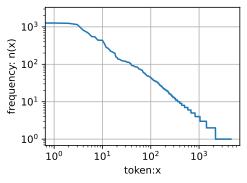

In [71]:
freqs = [freq for token, freq in vocab_words.token_freqs]
d2l.plot(freqs, xlabel='token:x', ylabel='frequency: n(x)', xscale='log', yscale='log')

Words in corpus follow the Zipflaw: word frequency tends to follow a power-law distribution

$
n_i = \frac{1}{i^{α}} ⇒ \log n_i = -α \log i + c
$

meaning that in the log-log space, it is a straight line.

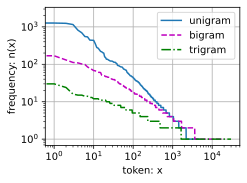

In [72]:
bigram_tokens = ['--'.join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

trigram_tokens = ['--'.join(triple) for triple in zip(
    words[:-2], words[1:-1], words[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

### Observations about n-grams

* the word distributation has a heavy tail
* other n-grams also follow the power-law distribution
* number of n_grams with larger n descreases.

## Partitioning Sequence

How to obtain features and labels for a corpus of indices that we constructed before for constructing a dataset? How to read minibatches of input sequences and target sequences at random?

Suppose we have a corpus of tokens/indices of size T. We will partition the corpus into subsequencies, where each subsequence has n (number of time steps that the model will handle) tokens. To iterate over (almost) all tokens in the entire dataset for each epoch and obtain all possible n-length subsequences we can introduce randomness.

1. At the beginning of each epoch, sample a random number $d\in [0, n)$. This injects randomness between epochs and makes sure we see all the length-n subsequencies across different epochs, while going over all the text in on epoch.
2. The rest of the sequence is then partitioned into $m = ⌊(T-d)/n⌋$ subsequencies of length n. The resulting subsequencies are $\bf{x}_d, \bf{x}_{d+n}, \bf{x}_{d+2n}, \bf{x}_{d+(m-1)n}$ where $\bf{x}_i$ represents the tokens starting from i to i+n-1. Each subsequence will be used as an input example/sequence to LM.
3. The target sequence for any $\bf{x}_t$ input sequence is the sequence shifted by 1 $\bf{x}_{t+1}$. I think we are doing n-ahead prediction and hence the targets are of size n.

This way we get m training examples of size n, with n target for n-ahead prediction, or could be discarded as needed.

**Important** is that this way, we get some form of randomness and the training examples are not very correletad, e.g. if used n and shifted by one. and we can also see a better sample of the dataset, rather just the first parts or end parts, but the whole dataset is used at each epoch.

In [76]:
@d2l.add_to_class(TimeMachine)
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    super(TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = torch.tensor([corpus[i : i+num_steps+1] for i in range(len(corpus) - num_steps)])
    self.X, self.Y = array[:,:-1], array[:,1:]

@d2l.add_to_class(TimeMachine)
def get_dataloader(self, train):
    idx = slice(0, self.num_train) if train else slice(self.num_train, self.num_train + self.num_val)
    return self.get_tensorloader([self.X, self.Y], train, idx)

In [80]:
data = TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.get_dataloader(True):
    print('X:', X, '\nY:', Y)
    break

X: tensor([[19, 10, 15,  8,  0, 14,  6, 21,  2, 13],
        [ 6, 15, 21, 13, 26,  0, 10, 15,  0, 16]]) 
Y: tensor([[10, 15,  8,  0, 14,  6, 21,  2, 13, 13],
        [15, 21, 13, 26,  0, 10, 15,  0, 16, 15]])
